# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [1]:
# import libraries
import numpy as np
import pandas as pd

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

from IPython.display import display

First, I will load the data. I will make the `datetime` column the index with a parsable data format.

In [2]:
# load data
df = pd.read_csv('/datasets/taxi.csv', index_col=['datetime'], parse_dates=['datetime'])

# view
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
# check info
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


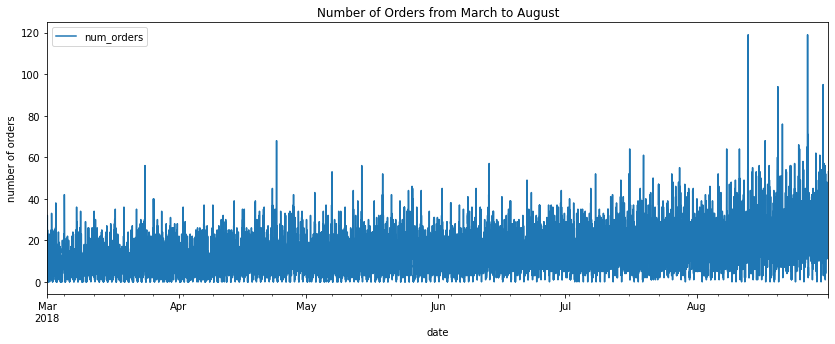

In [4]:
# view data
df.plot(xlabel='date', ylabel='number of orders', title='Number of Orders from March to August', figsize=(14, 5));

Because the `datetime` column was made into the index, there is one column, `num_orders`. Above is a graph that represents the data - It's hard to notice trends since the index is split into 10 minute intervals. I will resample the data so that it uses hour intervals instead. Since we want to predict the total number of orders in a given hour, I will resample by summing the number of orders per hour.

In [5]:
# resample by 1 hour
df = df.resample('1H').sum()

# see info
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


We have gone from 26496 rows to 4416 after the resampling - the data is ready to be analyzed.

## Analysis

### Dates


In [6]:
print(df.index.min())
print(df.index.max())

2018-03-01 00:00:00
2018-08-31 23:00:00


The data begins on March 1st, 2018 and goes through August 31st, 2018.

### Rolling Mean

As seen above, there are so many data points that it's hard to identify trends just by looking at the graph, even after resampling. So, first I will observe the resampled data's rolling mean. The rolling mean will give us a view of the average number of orders, smoothed over a period of time.

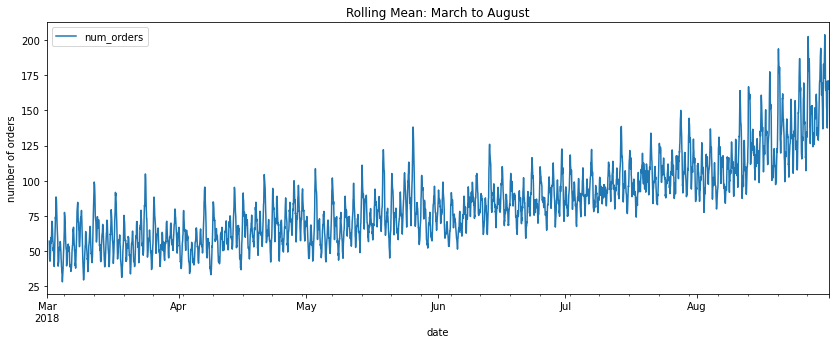

In [7]:
df.rolling(12).mean().plot(
    xlabel='date', ylabel='number of orders', title='Rolling Mean: March to August', figsize=(14, 5));

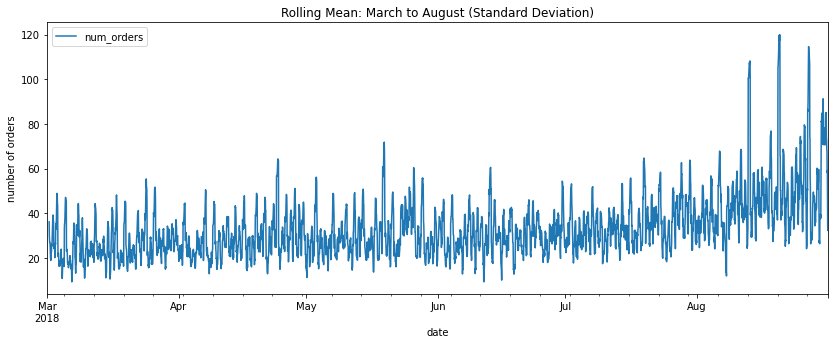

In [8]:
df.rolling(12).std().plot(
    xlabel='date', ylabel='number of orders', title='Rolling Mean: March to August (Standard Deviation)', figsize=(14, 5));

From the rolling mean above, we can see that the number of taxi orders have increased from March to August. In particular, the orders have shot up more noticeably throughout the months of July and August.

The bottom graph shows the standard deviation over time. It is consistent until August.

### Trend

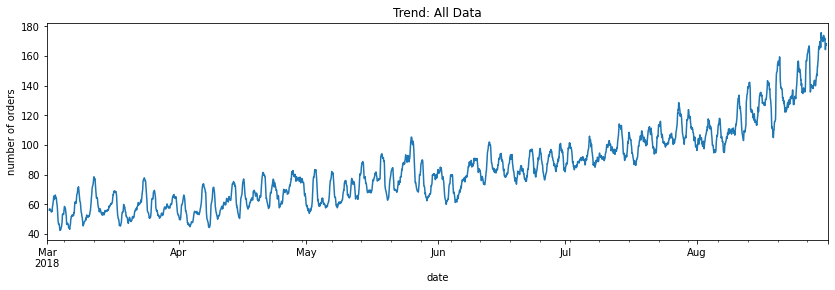

In [9]:
decomposed = seasonal_decompose(df)

# plot trends
decomposed.trend.plot(xlabel='date', title='Trend: All Data', ylabel='number of orders',figsize=(14, 4));

Above is a graph of the trend of the data. Similar to the rolling mean, it shows that the number of taxi orders have increased during the last half of the data.

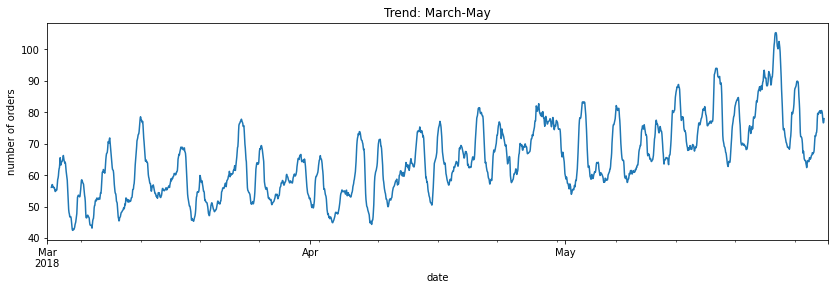

In [10]:
decomposed = seasonal_decompose(df['2018-03-01':'2018-05-31'])

# plot trends
decomposed.trend.plot(xlabel='date', title='Trend: March-May', ylabel='number of orders',figsize=(14, 4));

Above I am taking a closer look at the first half of the data. It appears that the month of March is consistent in the number of orders, but there is a general increase that begins in April.

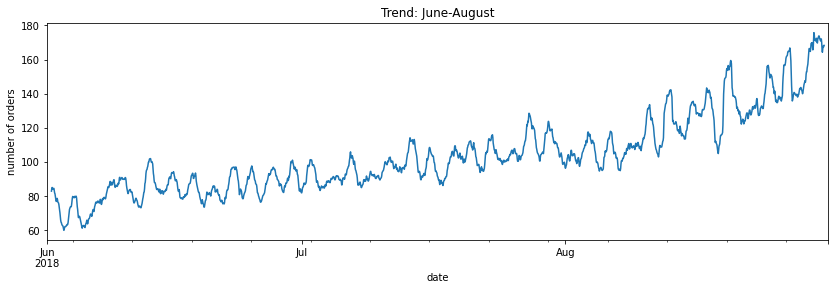

In [11]:
decomposed = seasonal_decompose(df['2018-06-01':'2018-08-31'])

# plot trends
decomposed.trend.plot(xlabel='date', title='Trend: June-August', ylabel='number of orders',figsize=(14, 4));

In the second half of the data, the trend continues to increase. During mid-August the number of orders increases more than previously.

### Standard Deviation

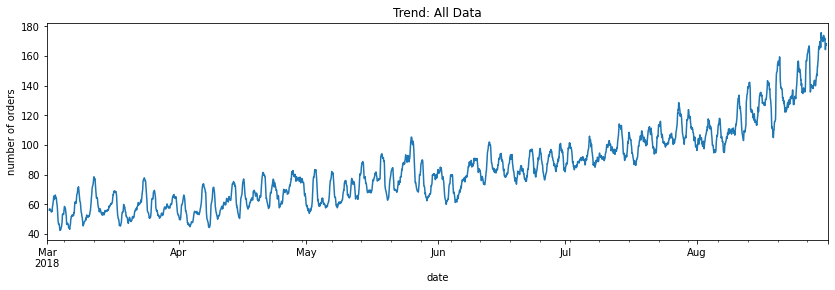

In [12]:
decomposed = seasonal_decompose(df)

# plot trends
decomposed.trend.plot(xlabel='date', title='Trend: All Data', ylabel='number of orders',figsize=(14, 4));


### Seasonality

Last, I will look at the data's seasonality. Seasonality shows repeating patterns, so it wouldn't make sense to show it in the entire graph. Instead, I'll plot one week of seasonality, March versus August.

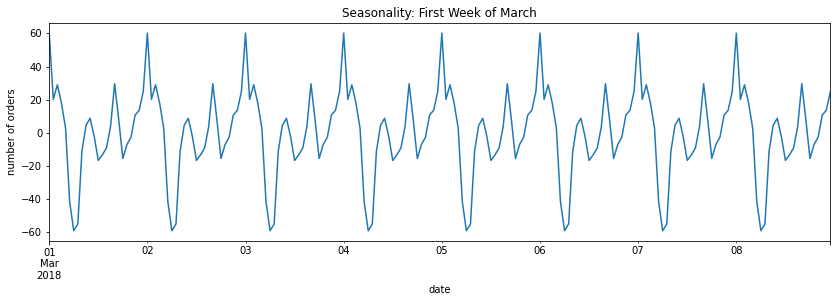

In [13]:
# plot one week seasonality - march
decomposed.seasonal['2018-03-01':'2018-03-08'].plot(xlabel='date', title='Seasonality: First Week of March', ylabel='number of orders',figsize=(14, 4));

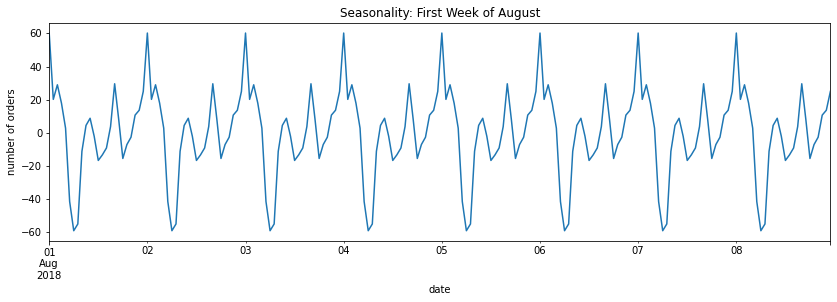

In [14]:
# plot one week seasonality - march
decomposed.seasonal['2018-08-01':'2018-08-08'].plot(xlabel='date', title='Seasonality: First Week of August', ylabel='number of orders',figsize=(14, 4));

We can see that both months have similar seasonalities.

### Making the Data Stationary

Time series data is an example of a stochastic process. A stochastic process is stationary if its distribution (including its mean and standard deviation) does not change over time. The data we are working with is non-stationary due to the change in mean. Non-stationary data is harder to forecast, so I will convert this data to a stationary process before the training begins.

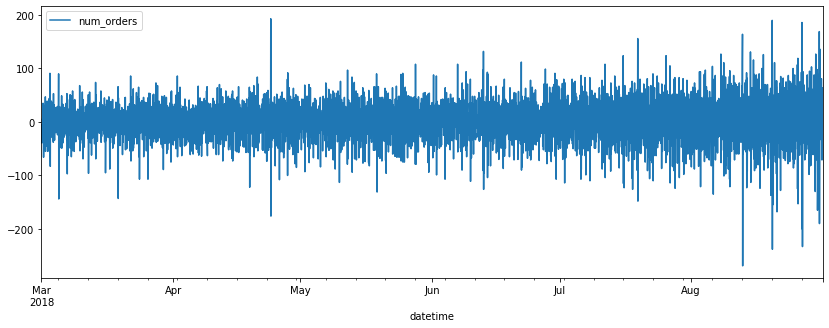

In [15]:
# take the difference of values to make the data stationary
df = df-df.shift()

df.plot(figsize=(14, 5));

The data is now more stationary.

## Preparing for Training

Before the data can be trained, I will extract useful features (including the year, month, day, day of week, and hour) from the indices. 

In [16]:
# create features based off index
def make_features(df, max_lag, rolling_mean_size):
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour

    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = (
        df['num_orders'].shift().rolling(rolling_mean_size).mean()
    )

make_features(df, 6, 10)

In [17]:
# view new features
df.tail()

,num_orders,year,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,,,,
2018-08-31 19:00:00,-71.0,2018,8,31,4,19,-10.0,20.0,81.0,-17.0,-33.0,30.0,2.5
2018-08-31 20:00:00,18.0,2018,8,31,4,20,-71.0,-10.0,20.0,81.0,-17.0,-33.0,-6.7
2018-08-31 21:00:00,5.0,2018,8,31,4,21,18.0,-71.0,-10.0,20.0,81.0,-17.0,-3.7
2018-08-31 22:00:00,64.0,2018,8,31,4,22,5.0,18.0,-71.0,-10.0,20.0,81.0,-0.8
2018-08-31 23:00:00,-18.0,2018,8,31,4,23,64.0,5.0,18.0,-71.0,-10.0,20.0,8.7


### Splitting Data

The initial data will be split into three datasets: A training set (80%) to train the model on, a validation set (10%) to tune hyperparameters/test models to, and a test set (10%) to verify the results of the chosen model.

In [18]:
# reserving 20% of the data for the valid/test datasets
df = df.dropna()
train, valid = train_test_split(df, shuffle=False, test_size=0.2, random_state=12345)

# splitting test/datasets to each be 10% of total data
valid, test = train_test_split(valid, shuffle=False, test_size=0.5, random_state=12345)

In [19]:
# validate sizes of created sets
print(f'Size of training set: {len(train) / len(df) * 100:.3}%')
print(f'Size of validation set: {len(valid) / len(df) * 100:.3}%')
print(f'Size of testing set: {len(test) / len(df) * 100:.3}%')

Size of training set: 80.0%
Size of validation set: 9.99%
Size of testing set: 10.0%


In [20]:
# get features and targets for train, valid, and test sets
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

Now that features have been created, model training can begin.

## Training

In [21]:
# empty dataframe to store model results
rmse_scores = pd.DataFrame(columns=['Model', 'RMSE'])

### Linear Regression

In [22]:
%%time

lr = LinearRegression()
lr.fit(features_train, target_train)
predicted_value = lr.predict(features_valid)
rmse = round(mean_squared_error(predicted_value, target_valid) ** 0.5, 2)

# add score to dataframe
rmse_scores = rmse_scores.append({'Model': 'Linear Regression', 'RMSE': rmse}, ignore_index=True)

print(f'Linear Regression RMSE: {rmse}')

Linear Regression RMSE: 41.64
CPU times: user 8.67 ms, sys: 19.8 ms, total: 28.5 ms
Wall time: 11.5 ms


Linear Regression is our sanity test. It ran in 12 seconds and has a RMSE of 41.64.

### Random Forest

In [23]:
%%time

best_rmse = float('inf')
best_depth = 0
best_est = 0

# looping through max depths
for depth in range(5, 10):

    # looping through number of estimators
    for est in range(10, 121, 10): 
        rf = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        
        rf.fit(features_train, target_train) 
        predictions_valid = rf.predict(features_valid)
        
        rmse = round(mean_squared_error(predictions_valid, target_valid) ** 0.5, 2)

        if rmse < best_rmse:
            best_rmse = rmse
            best_depth = depth
            best_est = est

# add score to dataframe
rmse_scores = rmse_scores.append({'Model': 'Random Forest', 'RMSE': best_rmse}, ignore_index=True)

print(f'Random Forest - Depth: {best_depth}; Est: {best_est}; RMSE: {best_rmse}')

Random Forest - Depth: 9; Est: 30; RMSE: 35.22
CPU times: user 49.3 s, sys: 85.1 ms, total: 49.4 s
Wall time: 49.4 s


The best Random Forest has a depth of 9 with 30 estimators. Its RMSE is 35.22, and it ran in 48 seconds testing all the hyperparameters.

### LightGBM

In [24]:
%%time

lgbm = LGBMRegressor(num_leaves=120, random_state=12345)
lgbm.fit(features_train, target_train)
predictions_valid = lgbm.predict(features_valid)
    
rmse = round(mean_squared_error(predictions_valid, target_valid) ** 0.5, 2)
    
# add score to dataframe
rmse_scores = rmse_scores.append({'Model': 'LightGBM', 'RMSE': rmse}, ignore_index=True)

print(f'LightGBM - RMSE: {rmse}')

LightGBM - RMSE: 34.18
CPU times: user 1.31 s, sys: 38.6 ms, total: 1.34 s
Wall time: 1.36 s


LightGBM took 1 second to run, and its RMSE is 34.18.

### CatBoost

In [25]:
%%time 

cat = CatBoostRegressor(loss_function="RMSE", iterations=150, random_state=12345)
cat.fit(features_train, target_train, verbose=10)
predictions_valid = cat.predict(features_valid)
rmse = round(mean_squared_error(predictions_valid, target_valid) ** 0.5, 2)

rmse_scores = rmse_scores.append({'Model': 'CatBoost', 'RMSE': rmse}, ignore_index=True)

print(f'CatBoost - RMSE: {rmse}')

Learning rate set to 0.233587
0:	learn: 32.2723921	total: 49ms	remaining: 7.3s
10:	learn: 24.6672742	total: 72.8ms	remaining: 921ms
20:	learn: 23.0641937	total: 102ms	remaining: 628ms
30:	learn: 21.9863762	total: 146ms	remaining: 559ms
40:	learn: 20.6780641	total: 184ms	remaining: 488ms
50:	learn: 19.8944737	total: 220ms	remaining: 428ms
60:	learn: 19.1254804	total: 257ms	remaining: 375ms
70:	learn: 18.4343161	total: 296ms	remaining: 330ms
80:	learn: 17.7115133	total: 334ms	remaining: 285ms
90:	learn: 17.1329272	total: 364ms	remaining: 236ms
100:	learn: 16.6194443	total: 388ms	remaining: 188ms
110:	learn: 16.1279770	total: 420ms	remaining: 147ms
120:	learn: 15.6110102	total: 444ms	remaining: 106ms
130:	learn: 15.1953252	total: 468ms	remaining: 67.8ms
140:	learn: 14.8407081	total: 492ms	remaining: 31.4ms
149:	learn: 14.5470435	total: 515ms	remaining: 0us
CatBoost - RMSE: 33.11
CPU times: user 490 ms, sys: 4.03 ms, total: 494 ms
Wall time: 636 ms


CatBoost ran very, very quickly (under 1 second) and has a RMSE of 33.11 seconds.

### XGBoost

In [26]:
%%time

xgb = XGBRegressor(random_state=12345)
xgb.fit(features_train, target_train)
predictions_valid = xgb.predict(features_valid)
rmse = round(mean_squared_error(predictions_valid, target_valid) ** 0.5, 2)

rmse_scores = rmse_scores.append({'Model': 'XGBoost', 'RMSE': rmse}, ignore_index=True)

print(f'XGBoost - RMSE: {rmse}')

XGBoost - RMSE: 34.82
CPU times: user 1.78 s, sys: 34.3 ms, total: 1.82 s
Wall time: 1.79 s


XGBoost ran in 2 seconds and had a RMSE of 34.82.

## Testing

In [27]:
rmse_scores

,Model,RMSE
0,Linear Regression,41.64
1,Random Forest,35.22
2,LightGBM,34.18
3,CatBoost,33.11
4,XGBoost,34.82


The models all performed similarly. CatBoost performed the best and ran the quickest, so it will be applied to the test data.

In [28]:
%%time

# join features and validation
combined_train = features_train.append(features_valid)
combined_target = target_train.append(target_valid)

cat = CatBoostRegressor(loss_function="RMSE", iterations=150, random_state=12345)
cat.fit(combined_train, combined_target, verbose=10)

predictions_test = cat.predict(features_test)
rmse = round(mean_squared_error(predictions_test, target_test) ** 0.5, 2)

print(f'CatBoost - RMSE: {rmse}')

Learning rate set to 0.23797
0:	learn: 33.6693053	total: 2.91ms	remaining: 433ms
10:	learn: 26.2715811	total: 29.7ms	remaining: 375ms
20:	learn: 24.4084414	total: 57.2ms	remaining: 351ms
30:	learn: 23.0789541	total: 84ms	remaining: 322ms
40:	learn: 22.0265859	total: 113ms	remaining: 301ms
50:	learn: 21.0447297	total: 138ms	remaining: 268ms
60:	learn: 20.1467009	total: 169ms	remaining: 247ms
70:	learn: 19.5290310	total: 195ms	remaining: 216ms
80:	learn: 18.9412825	total: 221ms	remaining: 188ms
90:	learn: 18.3209031	total: 247ms	remaining: 160ms
100:	learn: 17.8580975	total: 271ms	remaining: 132ms
110:	learn: 17.3382761	total: 297ms	remaining: 104ms
120:	learn: 16.7635963	total: 325ms	remaining: 77.8ms
130:	learn: 16.3054064	total: 351ms	remaining: 50.9ms
140:	learn: 15.9852970	total: 377ms	remaining: 24.1ms
149:	learn: 15.6767370	total: 400ms	remaining: 0us
CatBoost - RMSE: 44.05
CPU times: user 427 ms, sys: 4.15 ms, total: 432 ms
Wall time: 533 ms


With the test set, CatBoost results in a RMSE of 44.05.

## Conclusion

In this project, the historical airport data Sweet Lift Taxi collected was leveraged to create a model to predict the amount of taxi orders for the next hour. The data was first analyzed, and I noted that there was a general increasing trend in the second half of the data. Because non-stationary processes are harder to predict (as the mean and/or standard deviation fluctuate), the data was converted to a stationary process, and then five models were tested. Many of the models performed well. CatBoost was chosen for the final test data due to its low RMSE value and its speed.